# Artificial Neural Network (ANN) for Branch Prediction

This notebook implements a standard feedforward Artificial Neural Network to predict CPU branch behavior (Taken/Not Taken).

## Network Architecture:
- **Input Layer**: 64 neurons (32 PC bits + 32 Branch History bits)
- **Hidden Layer**: 16 neurons with ReLU activation
- **Output Layer**: 2 neurons (Taken / Not Taken) with Softmax

## Approach:
- Standard feedforward neural network using PyTorch
- Binary classification using Cross Entropy Loss
- Dropout for regularization
- Batch Normalization for stable training
- **Same architecture as SNN for fair comparison**

## 1. Setup Environment

In [1]:
!pip install torch pandas numpy scikit-learn matplotlib seaborn tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
# Check if GPU 1 exists, otherwise fall back to standard logic
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:1")
else:
    print("⚠️ GPU 1 not found. Falling back to default.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
print("✓ Libraries imported successfully!")

Using device: cuda:1
✓ Libraries imported successfully!


In [3]:
import sys
from datetime import datetime
import os
from IPython.display import display

class TeeLogger:
    """Logger that writes to both notebook output and file simultaneously"""
    def __init__(self, filename):
        # Store the original stdout (Jupyter's display system)
        self.terminal = sys.__stdout__
        self.log = open(filename, 'w', encoding='utf-8')
        
    def write(self, message):
        # Write to notebook output
        self.terminal.write(message)
        self.terminal.flush()
        # Write to log file
        self.log.write(message)
        self.log.flush()
        
    def flush(self):
        self.terminal.flush()
        self.log.flush()
        
    def close(self):
        self.log.close()
        sys.stdout = self.terminal

# Create outputs folder if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Generate timestamp for unique log file
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = f'outputs/ann_full_model_{timestamp}.log'

# Redirect stdout to TeeLogger
tee = TeeLogger(log_file)
sys.stdout = tee

print("="*70)
print(f"ANN Training Session Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Log file: {log_file}")
print("="*70 + "\n")

ANN Training Session Started: 2026-01-11 05:36:03
Log file: outputs/ann_full_model_20260111_053603.log

Loading dataset: data/branch_data_processed_01.csv

✓ Dataset loaded successfully!
Shape: (319203, 65)
Columns: 65

First few rows:
Features shape: (319203, 64)
Target shape: (319203,)

Target distribution:
  Not Taken (0): 140,179 (43.92%)
  Taken (1): 179,024 (56.08%)
✓ Sequential split (maintains execution order)
Training set size: 255,362 (first 80%)
Test set size: 63,841 (last 20%)
  y_train: torch.Size([255362])

Tensor shapes:
  X_train: torch.Size([255362, 64])
Batch size: 128
Training batches: 1996
Test batches: 499
Artificial Neural Network Architecture:
BranchPredictorANN(
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

Total parameters: 1,106
Loss function: Cross Entro

## 2. Load and Prepare Dataset

In [4]:
# Load the processed branch prediction dataset
data_file = 'data/branch_data_processed_01.csv'

print(f"Loading dataset: {data_file}")
df = pd.read_csv(data_file)

print(f"\n✓ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,BH_23,BH_24,BH_25,BH_26,BH_27,BH_28,BH_29,BH_30,BH_31,Taken
0,1,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
# Separate features and target
X = df.iloc[:, :64].values  # 64 input features (32 PC + 32 BH)
y = df.iloc[:, -1].values   # Target (0 or 1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Not Taken (0): {np.sum(y == 0):,} ({np.mean(y == 0)*100:.2f}%)")
print(f"  Taken (1): {np.sum(y == 1):,} ({np.mean(y == 1)*100:.2f}%)")

In [6]:
# Split into train and test sets SEQUENTIALLY (no shuffling)
# This preserves temporal order - crucial for branch prediction patterns!
split_idx = int(0.8 * len(X))
X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"✓ Sequential split (maintains execution order)")
print(f"Training set size: {len(X_train):,} (first 80%)")
print(f"Test set size: {len(X_test):,} (last 20%)")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print(f"  y_train: {y_train_tensor.shape}")

print(f"\nTensor shapes:")
print(f"  X_train: {X_train_tensor.shape}")

In [7]:
# Create DataLoaders
# shuffle=False to maintain sequential order!
batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

## 3. Define ANN Architecture

In [8]:
class BranchPredictorANN(nn.Module):
    """
    Artificial Neural Network for Branch Prediction
    
    Architecture:
    - Input: 64 neurons
    - Hidden Layer: 16 neurons + BatchNorm + ReLU + Dropout
    - Output: 2 neurons (Taken / Not Taken)
    """
    def __init__(self, input_size=64, hidden_size=16, output_size=2, dropout=0.3):
        super(BranchPredictorANN, self).__init__()
        
        # Hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        
        # Output layer
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Hidden layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Output layer
        x = self.fc2(x)
        
        return x


# Instantiate the model
model = BranchPredictorANN(
    input_size=64,
    hidden_size=16,
    output_size=2,
    dropout=0.3
).to(device)

print("Artificial Neural Network Architecture:")
print("="*50)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

## 4. Define Loss, Optimizer, and Training Functions

In [9]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Loss function: Cross Entropy Loss")
print("Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print("Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

In [10]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, test_loader, criterion, device):
    """Evaluate the model on test data."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Calculate accuracy
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, all_predictions, all_targets, all_probabilities

print("✓ Training and evaluation functions defined!")

## 5. Train the Model

In [11]:
# Training parameters
num_epochs = 5

# Lists to store training history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("="*70)
print(" "*20 + "TRAINING ARTIFICIAL NEURAL NETWORK")
print("="*70)
print(f"\nEpochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print("\n" + "-"*70)

try:
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        
        # Evaluate
        test_loss, test_acc, _, _, _ = evaluate(model, test_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(test_loss)
        
        # Store history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print progress
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    print("-"*70)
    print(f"\n✓ Training complete!")
    print(f"Best Test Accuracy: {max(test_accuracies):.2f}%")
    print(data_file)

except Exception as e:
    print(f"\n❌ Error during training: {e}")
    import traceback
    traceback.print_exc()

## 6. Visualize Training Results

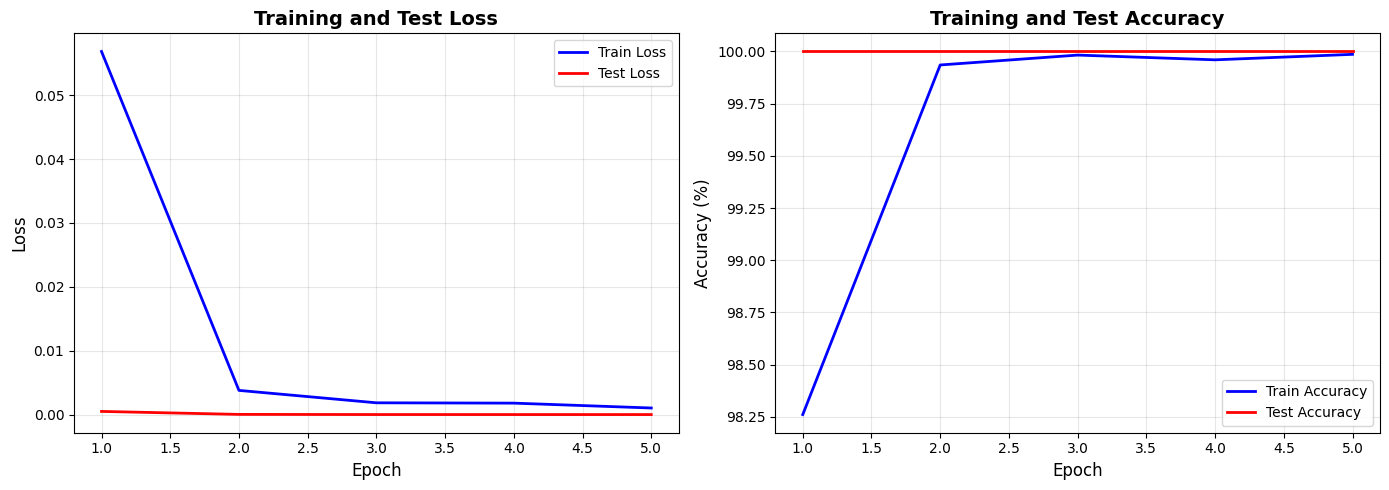

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0].plot(range(1, num_epochs+1), test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(range(1, num_epochs+1), test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/ann_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history saved to 'results/ann_training_history.png'")

## 7. Final Evaluation and Inference

In [13]:
# Final evaluation on test set
print("Running final inference on test set...\n")

test_loss, test_acc, predictions, targets, probabilities = evaluate(model, test_loader, criterion, device)

print("="*70)
print(" "*20 + "INFERENCE RESULTS")
print("="*70)

print(f"\n🎯 Test Accuracy: {test_acc:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# Classification report
print(f"\n📊 Classification Report:")
print("-"*50)
print(classification_report(targets, predictions, target_names=['Not Taken', 'Taken']))

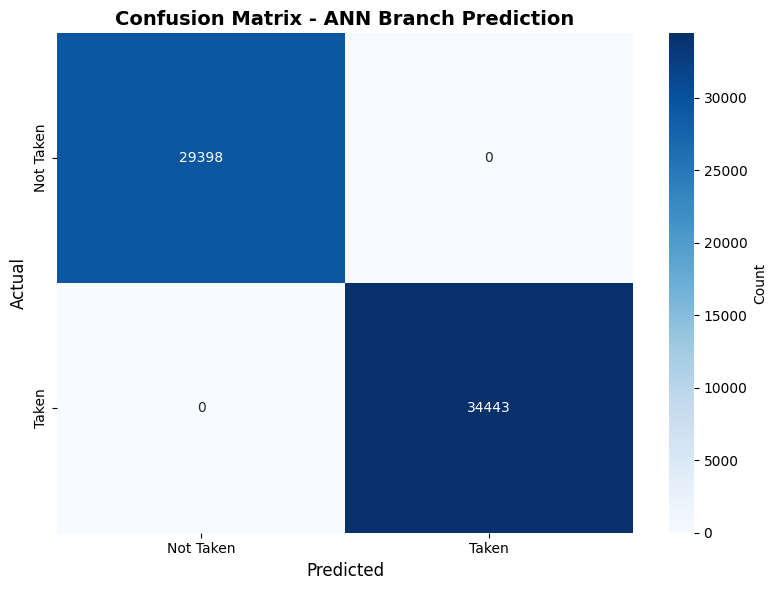

In [14]:
# Confusion Matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Taken', 'Taken'],
            yticklabels=['Not Taken', 'Taken'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ANN Branch Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('results/ann_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to 'results/ann_confusion_matrix.png'")

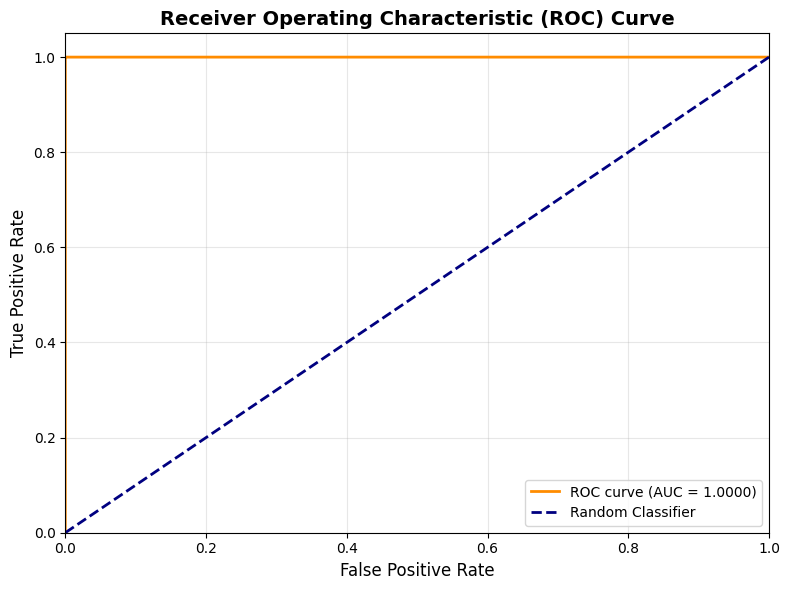

In [15]:
# ROC Curve
probabilities_np = np.array(probabilities)
fpr, tpr, thresholds = roc_curve(targets, probabilities_np[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/ann_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ ROC curve saved to 'results/ann_roc_curve.png'")
print(f"   AUC Score: {roc_auc:.4f}")

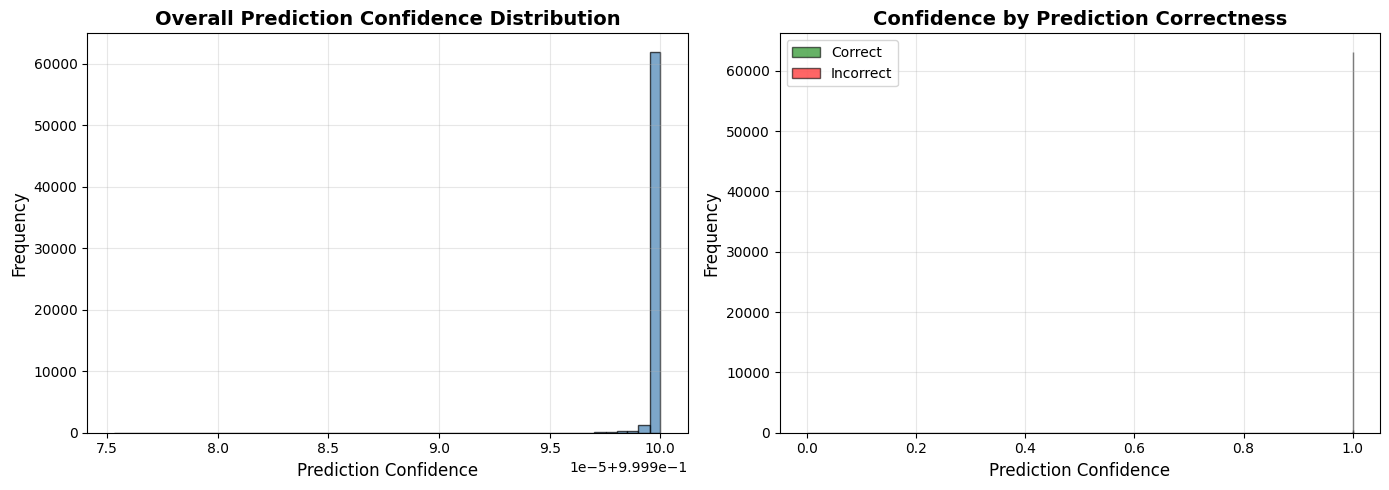

In [16]:
# Prediction confidence distribution
probabilities_np = np.array(probabilities)
max_probs = np.max(probabilities_np, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall confidence distribution
axes[0].hist(max_probs, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Overall Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Confidence by correctness
correct_mask = np.array(predictions) == np.array(targets)
correct_probs = max_probs[correct_mask]
incorrect_probs = max_probs[~correct_mask]

axes[1].hist(correct_probs, bins=30, alpha=0.6, label='Correct', color='green', edgecolor='black')
axes[1].hist(incorrect_probs, bins=30, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
axes[1].set_xlabel('Prediction Confidence', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Confidence by Prediction Correctness', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/ann_confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confidence distribution saved to 'results/ann_confidence_distribution.png'")

## 8. Save the Model

In [17]:
# Save the trained model
model_path = 'models/ann_branch_predictor.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies,
    'num_epochs': num_epochs,
    'final_accuracy': test_acc,
    'auc_score': roc_auc
}, model_path)

print(f"✓ Model saved to '{model_path}'")

## 9. Compare with SNN (Optional)

In [18]:
# Model comparison summary
print("="*70)
print(" "*20 + "ANN vs SNN COMPARISON")
print("="*70)

print("\n📊 Architecture (Both Models):")
print(f"   Input Layer: 64 neurons")
print(f"   Hidden Layer: 16 neurons")
print(f"   Output Layer: 2 neurons")

print("\n📊 ANN Model:")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Test Accuracy: {test_acc:.2f}%")
print(f"   AUC Score: {roc_auc:.4f}")
print(f"   Training Time: ~{num_epochs} epochs")

print("\n💡 Advantages of ANN:")
print("   ✓ Faster training and inference")
print("   ✓ More mature optimization techniques")
print("   ✓ Standard backpropagation")
print("   ✓ Easier to debug and tune")
print("   ✓ Better regularization options")

print("\n⚡ Advantages of SNN:")
print("   ✓ Biologically plausible")
print("   ✓ Event-driven computation")
print("   ✓ Potential for energy efficiency")
print("   ✓ Temporal dynamics modeling")
print("   ✓ Suitable for neuromorphic hardware")

print("\n" + "="*70)

## Summary

In [19]:
print("="*70)
print(" "*15 + "ARTIFICIAL NEURAL NETWORK - SUMMARY")
print("="*70)

print(f"\n📊 Network Architecture:")
print(f"   Input Layer: 64 neurons (32 PC + 32 Branch History bits)")
print(f"   Hidden Layer: 16 neurons (BatchNorm + ReLU + Dropout)")
print(f"   Output Layer: 2 neurons (Softmax)")
print(f"   Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\n⚙️ Training Configuration:")
print(f"   Epochs: {num_epochs}")
print(f"   Batch Size: {batch_size}")
print(f"   Learning Rate: 0.001 (adaptive)")
print(f"   Optimizer: Adam with weight decay")
print(f"   Dropout: 0.3")

print(f"\n📈 Dataset:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")

print(f"\n🎯 Final Results:")
print(f"   Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"   Test Accuracy: {test_acc:.2f}%")
print(f"   Best Test Accuracy: {max(test_accuracies):.2f}%")
print(f"   AUC Score: {roc_auc:.4f}")

print(f"\n💾 Saved Files:")
print(f"   Model: models/ann_branch_predictor.pth")
print(f"   Training History: results/ann_training_history.png")
print(f"   Confusion Matrix: results/ann_confusion_matrix.png")
print(f"   ROC Curve: results/ann_roc_curve.png")
print(f"   Confidence Distribution: results/ann_confidence_distribution.png")

print("\n" + "="*70)
print("✓ Implementation complete! ANN model trained successfully.")
print("="*70)

## 10. Feature Ablation Study - PC Only Model

Train an ANN using only Program Counter (PC) bits to evaluate their individual contribution to prediction accuracy.

In [20]:
# Close previous log and start new log for PC-only model
sys.stdout.close()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file_pc = f'outputs/ann_pc_only_{timestamp}.log'
tee_pc = TeeLogger(log_file_pc)
sys.stdout = tee_pc

print("\n" + "="*70)
print(f"ANN PC-Only Model Training Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Log file: {log_file_pc}")
print("="*70 + "\n")

In [21]:
# Prepare PC-only dataset (first 32 columns)
X_train_pc = X_train[:, :32]  # PC bits only
X_test_pc = X_test[:, :32]

print("PC-Only Dataset:")
print(f"  Training shape: {X_train_pc.shape}")
print(f"  Test shape: {X_test_pc.shape}")

# Convert to tensors
X_train_pc_tensor = torch.FloatTensor(X_train_pc)
X_test_pc_tensor = torch.FloatTensor(X_test_pc)

# Create DataLoaders
train_dataset_pc = TensorDataset(X_train_pc_tensor, y_train_tensor)
test_dataset_pc = TensorDataset(X_test_pc_tensor, y_test_tensor)

train_loader_pc = DataLoader(train_dataset_pc, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader_pc = DataLoader(test_dataset_pc, batch_size=batch_size, shuffle=False, drop_last=False)

print(f"  Training batches: {len(train_loader_pc)}")
print(f"  Test batches: {len(test_loader_pc)}")

In [22]:
# Create PC-only ANN model (32 inputs)
model_pc = BranchPredictorANN(
    input_size=32,  # Only PC bits
    hidden_size=16,
    output_size=2,
    dropout=0.3
).to(device)

print("\n📊 PC-Only ANN Architecture:")
print("="*50)
print(f"   Input: 32 neurons (PC bits only)")
print(f"   Hidden: 16 neurons (BatchNorm + ReLU + Dropout)")
print(f"   Output: 2 neurons")
print(f"   Parameters: {sum(p.numel() for p in model_pc.parameters()):,}")

# Setup optimizer and scheduler for PC model
optimizer_pc = torch.optim.Adam(model_pc.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_pc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_pc, mode='min', factor=0.5, patience=3)

In [23]:
# Train PC-only model
train_losses_pc = []
train_accuracies_pc = []
test_losses_pc = []
test_accuracies_pc = []

print("\n" + "="*70)
print(" "*18 + "TRAINING PC-ONLY ANN MODEL")
print("="*70)
print(f"Input features: PC bits only (32 neurons)")
print("-"*70)

try:
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model_pc, train_loader_pc, optimizer_pc, criterion, device)
        test_loss, test_acc, _, _, _ = evaluate(model_pc, test_loader_pc, criterion, device)
        scheduler_pc.step(test_loss)
        
        train_losses_pc.append(train_loss)
        train_accuracies_pc.append(train_acc)
        test_losses_pc.append(test_loss)
        test_accuracies_pc.append(test_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    print("-"*70)
    print(f"✓ PC-Only Model Training Complete!")
    print(f"   Best Test Accuracy: {max(test_accuracies_pc):.2f}%")
    print(f"   Final Test Accuracy: {test_accuracies_pc[-1]:.2f}%")
    print(data_file)
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

## 11. Feature Ablation Study - Branch History Only Model

Train an ANN using only Branch History bits to evaluate their individual contribution to prediction accuracy.

In [24]:
# Close previous log and start new log for Branch History-only model
sys.stdout.close()
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file_bh = f'outputs/ann_bh_only_{timestamp}.log'
tee_bh = TeeLogger(log_file_bh)
sys.stdout = tee_bh

print("\n" + "="*70)
print(f"ANN Branch History-Only Model Training Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Log file: {log_file_bh}")
print("="*70 + "\n")

In [25]:
# Prepare Branch History-only dataset (columns 32-63)
X_train_bh = X_train[:, 32:64]  # Branch History bits only
X_test_bh = X_test[:, 32:64]

print("Branch History-Only Dataset:")
print(f"  Training shape: {X_train_bh.shape}")
print(f"  Test shape: {X_test_bh.shape}")

# Convert to tensors
X_train_bh_tensor = torch.FloatTensor(X_train_bh)
X_test_bh_tensor = torch.FloatTensor(X_test_bh)

# Create DataLoaders
train_dataset_bh = TensorDataset(X_train_bh_tensor, y_train_tensor)
test_dataset_bh = TensorDataset(X_test_bh_tensor, y_test_tensor)

train_loader_bh = DataLoader(train_dataset_bh, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader_bh = DataLoader(test_dataset_bh, batch_size=batch_size, shuffle=False, drop_last=False)

print(f"  Training batches: {len(train_loader_bh)}")
print(f"  Test batches: {len(test_loader_bh)}")

In [26]:
# Create Branch History-only ANN model (32 inputs)
model_bh = BranchPredictorANN(
    input_size=32,  # Only Branch History bits
    hidden_size=16,
    output_size=2,
    dropout=0.3
).to(device)

print("\n📊 Branch History-Only ANN Architecture:")
print("="*50)
print(f"   Input: 32 neurons (Branch History bits only)")
print(f"   Hidden: 16 neurons (BatchNorm + ReLU + Dropout)")
print(f"   Output: 2 neurons")
print(f"   Parameters: {sum(p.numel() for p in model_bh.parameters()):,}")

# Setup optimizer and scheduler for BH model
optimizer_bh = torch.optim.Adam(model_bh.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_bh = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_bh, mode='min', factor=0.5, patience=3)

In [27]:
# Train Branch History-only model
train_losses_bh = []
train_accuracies_bh = []
test_losses_bh = []
test_accuracies_bh = []

print("\n" + "="*70)
print(" "*13 + "TRAINING BRANCH HISTORY-ONLY ANN MODEL")
print("="*70)
print(f"Input features: Branch History bits only (32 neurons)")
print("-"*70)

try:
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model_bh, train_loader_bh, optimizer_bh, criterion, device)
        test_loss, test_acc, _, _, _ = evaluate(model_bh, test_loader_bh, criterion, device)
        scheduler_bh.step(test_loss)
        
        train_losses_bh.append(train_loss)
        train_accuracies_bh.append(train_acc)
        test_losses_bh.append(test_loss)
        test_accuracies_bh.append(test_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    print("-"*70)
    print(f"✓ Branch History-Only Model Training Complete!")
    print(f"   Best Test Accuracy: {max(test_accuracies_bh):.2f}%")
    print(f"   Final Test Accuracy: {test_accuracies_bh[-1]:.2f}%")
    print(data_file)
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

## 12. Compare All Three Models

Compare the performance of Full model (PC + BH), PC-only model, and Branch History-only model.

In [28]:
# Final evaluation for all models
print("\n" + "="*70)
print(" "*15 + "FEATURE ABLATION STUDY - RESULTS")
print("="*70)

# Get final test accuracies
_, acc_full, _, _, _ = evaluate(model, test_loader, criterion, device)
_, acc_pc, _, _, _ = evaluate(model_pc, test_loader_pc, criterion, device)
_, acc_bh, _, _, _ = evaluate(model_bh, test_loader_bh, criterion, device)

print("\n📊 Model Comparison:")
print("-"*70)
print(f"{'Model':<30} {'Input Features':<20} {'Test Accuracy':<15}")
print("-"*70)
print(f"{'Full Model (PC + BH)':<30} {'64 neurons':<20} {acc_full:>6.2f}%")
print(f"{'PC-Only Model':<30} {'32 neurons':<20} {acc_pc:>6.2f}%")
print(f"{'Branch History-Only Model':<30} {'32 neurons':<20} {acc_bh:>6.2f}%")
print("-"*70)

print("\n🔍 Feature Importance Analysis:")
print(f"   Full Model Accuracy: {acc_full:.2f}%")
print(f"   PC Contribution: {acc_pc:.2f}%")
print(f"   Branch History Contribution: {acc_bh:.2f}%")
print(f"   Synergy (Full - Max(PC, BH)): {acc_full - max(acc_pc, acc_bh):.2f}%")

if acc_pc > acc_bh:
    print(f"\n💡 PC bits are more predictive ({acc_pc:.2f}% vs {acc_bh:.2f}%)")
elif acc_bh > acc_pc:
    print(f"\n💡 Branch History bits are more predictive ({acc_bh:.2f}% vs {acc_pc:.2f}%)")
else:
    print(f"\n💡 PC and Branch History have equal predictive power")

print("\n" + "="*70)

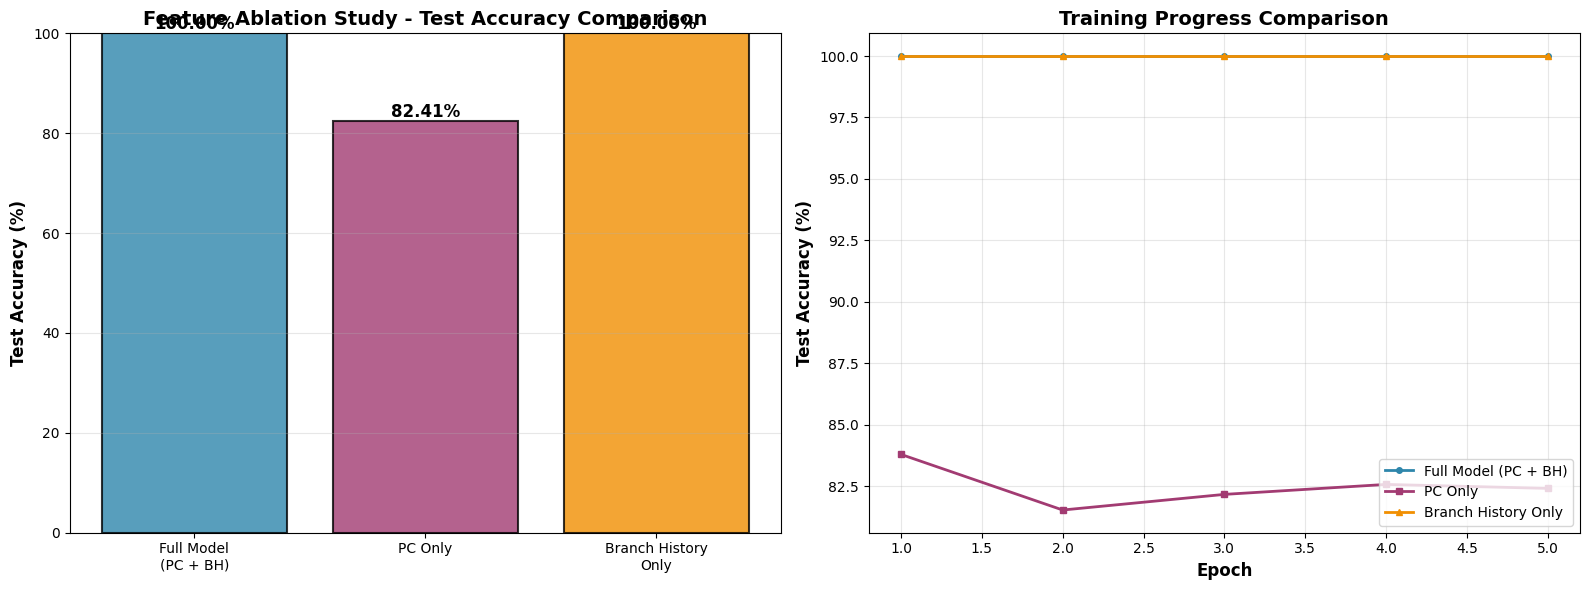

In [29]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
models = ['Full Model\n(PC + BH)', 'PC Only', 'Branch History\nOnly']
accuracies = [acc_full, acc_pc, acc_bh]
colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Feature Ablation Study - Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Training history comparison
axes[1].plot(range(1, num_epochs+1), test_accuracies, 'o-', label='Full Model (PC + BH)', 
            linewidth=2, markersize=4, color=colors[0])
axes[1].plot(range(1, num_epochs+1), test_accuracies_pc, 's-', label='PC Only', 
            linewidth=2, markersize=4, color=colors[1])
axes[1].plot(range(1, num_epochs+1), test_accuracies_bh, '^-', label='Branch History Only', 
            linewidth=2, markersize=4, color=colors[2])
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Training Progress Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/ann_feature_ablation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Feature ablation comparison saved to 'results/ann_feature_ablation_comparison.png'")

In [30]:
# Save all models
torch.save({
    'model_state_dict': model_pc.state_dict(),
    'optimizer_state_dict': optimizer_pc.state_dict(),
    'test_accuracies': test_accuracies_pc,
    'final_accuracy': acc_pc
}, 'models/ann_pc_only.pth')

torch.save({
    'model_state_dict': model_bh.state_dict(),
    'optimizer_state_dict': optimizer_bh.state_dict(),
    'test_accuracies': test_accuracies_bh,
    'final_accuracy': acc_bh
}, 'models/ann_bh_only.pth')

print("✓ PC-Only model saved to 'models/ann_pc_only.pth'")
print("✓ Branch History-Only model saved to 'models/ann_bh_only.pth'")

In [31]:
# Close all log files and restore stdout
print("\n" + "="*70)
print(f"Training Session Ended: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

sys.stdout.close()
sys.stdout = sys.__stdout__  # Restore original stdout

print("\n✓ All logs saved to 'outputs/' folder:")
print(f"  - Full Model: {log_file if 'log_file' in dir() else 'N/A'}")
print(f"  - PC-Only: {log_file_pc if 'log_file_pc' in dir() else 'N/A'}")
print(f"  - BH-Only: {log_file_bh if 'log_file_bh' in dir() else 'N/A'}")